# Spiking VSA Spatial Memory

## Prelims

In [1]:
from numpy import *
from matplotlib.pyplot import *
from tqdm import tqdm

In [2]:
from phasorutils import *
from brian2 import *
from numpy import *
from matplotlib.pyplot import *
from spikingVSA import *
from copy import deepcopy
from IPython.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))
import time

%load_ext autoreload
%autoreload 2

## Simple query

In [3]:
ssp = HexSSP(thetas=arange(0, 120, 15), scales=linspace(0.1, pi, 20))
M = 10
N = ssp.dimension()
#ds = SparsePhaseMap(M=M, N=N, sparsity=0.1)
ds = SparsePhaseMap(M=M, N=N, sparsity=1.)
#ds = SymmetricPhaseMap(M=M, N=N, sparsity=1.)

Number of phasors: 2


## Theoretical (Complex)

In [4]:
class thing():
    def __init__(self, v, label):
        self.v = v
        self.label = label

class xyaxis():
    def __init__(self, S):
        self.vec = S
    def __getitem__(self, idx):
        return self.vec[idx]
        
class vocab():
    def __init__(self, dim):
        self.dim = dim
        self.stuff = []
        
    def list_labels(self):
        for k,obj in enumerate(self.stuff):
            print(f'{k}: {self[k].label}')
            
    def all_labels(self):
        alll = []
        for obj in self.stuff:
            alll.append(obj.label)
        return array(alll)
    
    def all_vectors(self):
        allv = []
        for obj in self.stuff:
            allv.append(obj.v)
        return array(allv)
            
    def add(self, v, label):
        self.stuff.append(thing(v, label))
        
    def add_combinations(self, idxs1, idxs2):
        '''
        Adds all combinations of things from index list idxs1 with
        things from index list idxs2.
        '''
        for k1 in idxs1:
            for k2 in idxs2:
                self.add(self[k1].v * self[k2].v, f'{self[k1].label} {self[k2].label}')
        
    def __getitem__(self, idx):
        return self.stuff[idx]

In [5]:
V = vocab(N)

V.add(ds.S[0], 'red')
V.add(ds.S[1], 'blue')
V.add(ds.S[2], 'green')
V.add(ds.S[3], 'square')
V.add(ds.S[4], 'circle')
V.add(ds.S[5], 'triangle')

X = xyaxis(ssp.S)
xscale = 0.5
yscale = 0.5

V.add_combinations([0,1,2], [3,4,5])

In [6]:
V.list_labels()

0: red
1: blue
2: green
3: square
4: circle
5: triangle
6: red square
7: red circle
8: red triangle
9: blue square
10: blue circle
11: blue triangle
12: green square
13: green circle
14: green triangle


In [7]:
rsx = [-1.3, -1.1]
rs = V[6].v * X[0]**(rsx[0]/xscale) * X[1]**(rsx[1]/yscale)

In [8]:
bcx = [1.2, 0.5]
bc = V[10].v * X[0]**(bcx[0]/xscale) * X[1]**(bcx[1]/yscale)

In [9]:
gtx = [-1.4, 1.7]
gt = V[14].v * X[0]**(gtx[0]/xscale) * X[1]**(gtx[1]/yscale)

In [10]:
similarity(V[1].v, V.all_vectors())

(1,
 array([0.00963765, 0.99999994, 0.03847289, 0.04648601, 0.07800996,
        0.0424448 , 0.00577704, 0.02615583, 0.03241128, 0.0104993 ,
        0.03774906, 0.01971221, 0.01843742, 0.0544295 , 0.04930932],
       dtype=float32))

In [11]:
F = rs + bc + gt
F /= abs(F)

In [12]:
q = X[0]**(bcx[0]/xscale) * X[1]**(bcx[1]/yscale)
q = X[0]**(gtx[0]/xscale) * X[1]**(gtx[1]/yscale)

In [13]:
max_i, sims = similarity(F * conj(q), V.all_vectors())
print(V[max_i].label)

green triangle


In [14]:
sims

array([0.03551611, 0.03927748, 0.03651283, 0.02569997, 0.0495993 ,
       0.00842554, 0.01235494, 0.05207514, 0.02283329, 0.0071251 ,
       0.03955475, 0.09431843, 0.04310193, 0.01859768, 0.49473504])

In [15]:
n_samples = 201
radius = 2
# xrange = [-2, 2]
# yrange = [-2, 2]
xvals = linspace(-radius, radius, n_samples)
yvals = linspace(-radius, radius, n_samples)

q = sum(V.all_vectors(), axis=0)
q = V[10].v + V[14].v
q /= abs(q)

allfx = complex_similarity_2D(F * conj(q), ssp.S, yvals/yscale, xvals/xscale)

sx = []
for col in allfx.T:
    k = argmax(col)
    sx.append(yvals[k])
sx = array(sx)

In [16]:
def draw_shapes():
    lw = 5
    circle = plt.Circle(bcx, 0.25, fc='none', ec='blue', lw=lw)
    plt.gca().add_patch(circle); plot(bcx[0], bcx[1], 'b+')
    square = plt.Rectangle(array(rsx)-array([0.25,0.25]), 0.5, 0.5, fc='none', ec='red', lw=lw)
    plt.gca().add_patch(square); plot(rsx[0], rsx[1], 'r+')
    pts = array([[-0.25, -0.18],[0.25, -0.18],[0,0.27]])
    triangle = Polygon(gtx+pts, fc='none', ec='green', lw=lw)
    plt.gca().add_patch(triangle); plot(gtx[0], gtx[1], 'g+')

In [17]:
font = {'size': 18}
matplotlib.rc('font', **font)

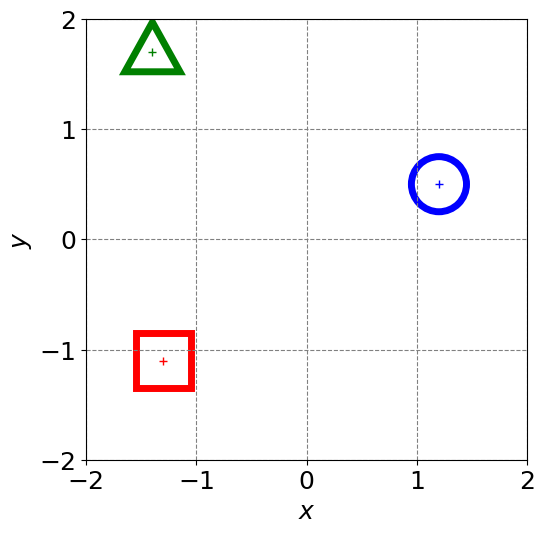

In [18]:
figure(figsize=(3*radius, 3*radius))
imshow(allfx.T, extent=(-radius, radius,-radius, radius), origin='lower', alpha=0.0)#, cmap='jet');
grid('on', ls='--', color='gray'); xlabel(r'$x$'); ylabel(r'$y$');
draw_shapes(); tight_layout();
xticks(arange(-radius, radius+1.e-5, 1))
yticks(arange(-radius, radius+1.e-5, 1))
savefig('object_locations.pdf')

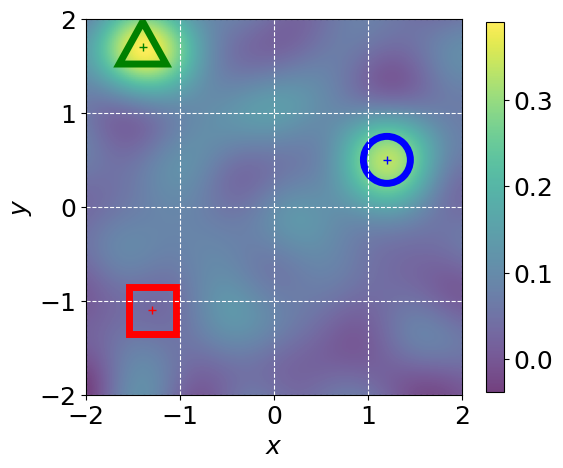

In [26]:
figure(figsize=(3*radius, 3*radius))
imshow(allfx.T, extent=(-radius, radius,-radius, radius), origin='lower', alpha=0.75)#, cmap='jet');
colorbar(shrink=0.7);
grid('on', ls='--', color='w'); xlabel(r'$x$'); ylabel(r'$y$');
draw_shapes(); tight_layout();
xticks(arange(-radius, radius+1.e-5, 1))
yticks(arange(-radius, radius+1.e-5, 1))
#savefig('object_heatmap.pdf')

## Spiking Phasors

In [27]:
# Spiking bundling
net = SpikingPhasorNet()
freq = 10.

Fpop = GenerateSP(N=N, C=F, freq=freq); net.add_pop(Fpop)

x = rsx

q = X[0]**(x[0]/xscale) * X[1]**(x[1]/yscale)
Q1 = GenerateSP(N=N, C=q, freq=freq); net.add_pop(Q1)

# What is at the location?
Z1 = PhaseDiffPop(N=N, freq=freq); net.add_pop(Z1)
net.deconvolve(Fpop, Q1, Z1)

relay3 = SpikingPhasorPop(N=N, freq=freq, stop_at=1.); net.add_pop(relay3)
net.connect(Z1, relay3, W=eye(N))

m3 = SpikingModernHopfield(V.all_vectors(), freq=freq); net.add_pop(m3)
net.connect(relay3, m3, W=eye(N))

print(f'Encoding dimension: {N}')
print(f'Total number of neurons: {net.total_neurons()}')

Encoding dimension: 480
Total number of neurons: 2415


In [28]:
m3.total_neurons()

495

In [29]:
start = time.time()
net.run(2*second)
duration = time.time() - start
print(f'Time: {duration}')

Time: 11.169757843017578


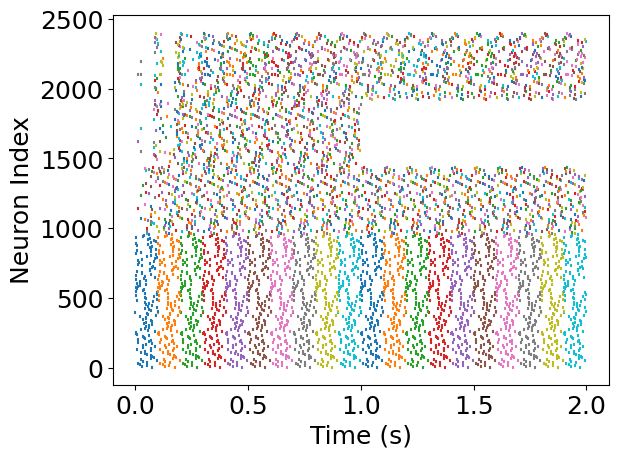

In [30]:
net.spike_raster()

('red', 0.005358169393601443)
('blue', 0.0665949253114256)
('green', 0.05246851585204863)
('square', -0.011110095447903427)
('circle', 0.04339043521096726)
('triangle', -0.03930695746852068)
('red square', 0.9999049010504221)
('red circle', -0.011333970349316392)
('red triangle', -0.007117932439602051)
('blue square', -0.05320588713217353)
('blue circle', 0.02137375988128349)
('blue triangle', 0.05477207907819228)
('green square', -0.023427126240833297)
('green circle', -0.04064356903121639)
('green triangle', -0.0006264312529361886)


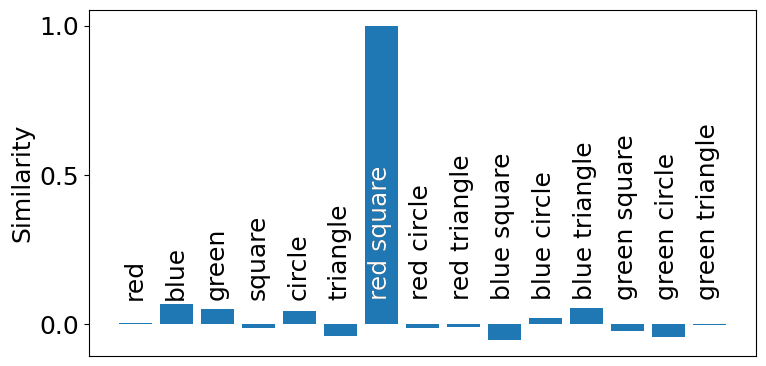

In [31]:
# What is at location x1?
max_k, sims = spiking_similarity(m3, V.all_vectors(), 1.9)
print(*list(zip(V.all_labels(),sims)), sep='\n')
V[max_k].label
idxs = range(len(sims))

figure(figsize=(8,4))
bar(idxs, sims);

fs = 18
nudge = 0.32
for k in range(len(V.stuff)):
    text(k-nudge, 0.1, V[k].label, fontsize=fs, rotation=90);
text(max_k-nudge, 0.1, V[max_k].label, color='white', fontsize=fs, rotation=90);
ylabel('Similarity'); yticks([0, 0.5, 1]);
xticks([]); tight_layout();
savefig('sim_barplot.pdf');

In [32]:
# Spiking bundling
net = SpikingPhasorNet()

Fpop = GenerateSP(N=N, C=F, freq=freq); net.add_pop(Fpop)

q = V[10].v + V[14].v
q /= abs(q)

Q1 = GenerateSP(N=N, C=q, freq=freq); net.add_pop(Q1)

# Where is the red square?
Z1 = PhaseDiffPop(N=N, freq=freq); net.add_pop(Z1)
net.deconvolve(Fpop, Q1, Z1)


In [33]:
net.total_neurons()

1440

In [34]:
start = time.time()
net.run(1.5*second)
duration = time.time() - start
print(f'Time: {duration}')

Time: 1.4151349067687988


In [35]:
v = Z1.spikes2complex(1.4)

n_samples = 201
radius = 2
# xrange = [-2, 2]
# yrange = [-2, 2]
xvals = linspace(-radius, radius, n_samples)
yvals = linspace(-radius, radius, n_samples)

heatmap = complex_similarity_2D(v, ssp.S, yvals/yscale, xvals/xscale)


In [36]:
k = argmax(ravel(heatmap))
maxc, maxr = unravel_index(k, heatmap.shape)

Max of 0.3897116676960934 at (31, 185); true (-1.3, -1.1)


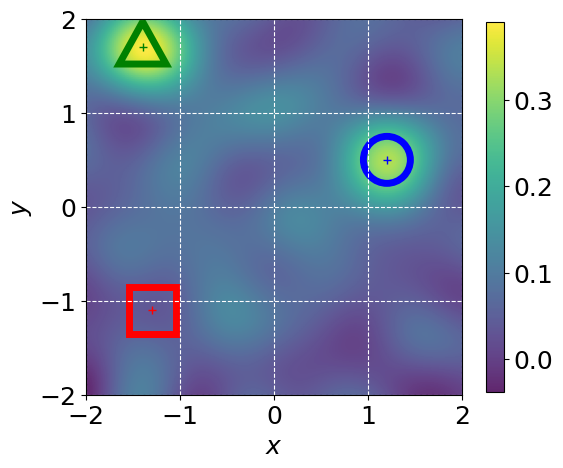

In [39]:
figure(figsize=(3*radius, 3*radius))
imshow(heatmap.T, extent=(-radius, radius,-radius, radius), origin='lower', alpha=0.85)#, cmap='hot');
colorbar(shrink=0.7);
grid('on', ls='--', color='w'); xlabel(r'$x$'); ylabel(r'$y$');
draw_shapes(); tight_layout();
xticks(arange(-radius, radius+1.e-5, 1))
yticks(arange(-radius, radius+1.e-5, 1))
savefig('object_locations.pdf')
print(f'Max of {heatmap[maxc,maxr]} at ({maxc}, {maxr}); true ({rsx[0]}, {rsx[1]})');